In [1]:
from numpy.random import seed
import numpy as np
seed(1)
from tensorflow import set_random_seed
set_random_seed(2)

import tensorflow as tf
# from tensorflow.python.keras.optimizers import Fire
from tensorflow.python.keras.optimizers import Adam
from tensorflow.python.keras import backend as K
from tensorflow.python.keras import optimizers

from sklearn import preprocessing
from sklearn.neural_network import MLPClassifier
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import log_loss

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data
from torch.autograd import Variable
from torchsummary import summary


import matplotlib.pyplot as plt
%matplotlib inline


## Preparing the input data

In [2]:
#Preparing the input data

#loading the MNIST dataset
mnist = tf.keras.datasets.mnist

#Separating into train and test (60000 train, 10000 test)
(x_train, y_train0),(x_test, y_test0) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

#flattening the images (from 28x28 to 784)
x_train = x_train.reshape(60000, 784)
x_test = x_test.reshape(10000, 784)


#converting the otputs (labels) into one hot vectors
lb = preprocessing.LabelBinarizer()
lb.fit(np.array([0,1,2,3,4,5,6,7,8,9]))
y_train = lb.transform(y_train0)
y_test = lb.transform(y_test0)


## Defining the input parameters


In [3]:
#Defining the input parameters
BatchSize         = 128
NeuronsLayer1     = 1000
NeuronsLayer2     = 1000
Epochs            = 25

## PyTorch

In [4]:
# Create Tensors to hold inputs and outputs

torch_X_train = torch.from_numpy(x_train)
torch_y_train = torch.from_numpy(y_train)

#the trainloader helps us deal with the batches
train = torch.utils.data.TensorDataset(torch_X_train.float(),torch_y_train.float())
train_loader = torch.utils.data.DataLoader(train, batch_size = BatchSize, shuffle = False)


In [5]:
# Defining the net

class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.linear1 = nn.Linear(784,NeuronsLayer1)
        self.linear2 = nn.Linear(NeuronsLayer1,NeuronsLayer2)
        self.linear3 = nn.Linear(NeuronsLayer2,10)
        nn.init.xavier_uniform_(self.linear1.weight)
        nn.init.zeros_(self.linear1.bias)
        nn.init.xavier_uniform_(self.linear2.weight)
        nn.init.zeros_(self.linear2.bias)
        nn.init.xavier_uniform_(self.linear3.weight)
        nn.init.zeros_(self.linear3.bias)
    
    def forward(self,X):
        X = F.relu(self.linear1(X))
        X = F.relu(self.linear2(X))
        X = F.softmax(self.linear3(X), dim=1)
        return X


In [6]:
# Construct our model by instantiating the class defined above.
model = MLP()


# Construct our loss function and an Optimizer. 

#it seems that cateorical cross-entropy is not available in pytorch. We have to make or own
#    implementation of the loss function
#https://datascience.stackexchange.com/questions/55962/pytorch-doing-a-cross-entropy-loss-when-the-predictions-already-have-probabiliti
def categorical_cross_entropy(y_pred, y_true):
    y_pred = torch.clamp(y_pred, 1e-9, 1 - 1e-9)
    return -(y_true * torch.log(y_pred)).sum(dim=1).mean()

optimizer = torch.optim.Adam(model.parameters())


In [7]:
#Show aprameters of the network
model.parameters

<bound method Module.parameters of MLP(
  (linear1): Linear(in_features=784, out_features=1000, bias=True)
  (linear2): Linear(in_features=1000, out_features=1000, bias=True)
  (linear3): Linear(in_features=1000, out_features=10, bias=True)
)>

In [8]:
#train the network

loss_history = []
for epoch in range(Epochs):
    loss_avg = 0.0
    N_elements = 0
    for batch_idx, (X_batch, y_batch) in enumerate(train_loader):
        # Forward pass: Compute predicted y by passing x to the model
        y_pred = model(X_batch)

        # Compute loss
        loss = categorical_cross_entropy(y_pred, y_batch)

        # Zero gradients, perform a backward pass, and update the weights.
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        loss_avg += loss.item()*X_batch.size()[0]
        N_elements += X_batch.size()[0]

    # print loss after each epoch    
    print(epoch+1, loss.item(), loss_avg/N_elements)
    loss_history.append(loss_avg/N_elements)


1 0.23358498513698578 0.21181656583150227
2 0.19137690961360931 0.0806490621238947
3 0.17116929590702057 0.048884189785147705
4 0.10802432149648666 0.034384877207440635
5 0.09495166689157486 0.02562943718902146
6 0.05624447762966156 0.024850268858050306
7 0.04343125596642494 0.02009575437436094
8 0.018005818128585815 0.01811603599470885
9 0.0663447231054306 0.016320256350100197
10 0.03068823553621769 0.013540293621442592
11 0.010280144400894642 0.01341341297814021
12 0.011226601898670197 0.014850486832386378
13 0.08036751300096512 0.013193333620249176
14 0.0018241816433146596 0.012317170352938896
15 0.0035595509689301252 0.012837048443958823
16 0.003368053352460265 0.008105528890066004
17 0.0016647485317662358 0.008739268647076581
18 0.0018818069947883487 0.00803387965749868
19 0.039421647787094116 0.006148612601697823
20 0.00043233903124928474 0.012139673285445315
21 0.0046593076549470425 0.01451756894767459
22 0.02447478473186493 0.005327977715104991
23 0.04555784538388252 0.00601290

In [9]:
#Predicting
y_train_hat_Pytorch = model(torch_X_train.float()).detach().numpy()

print(log_loss(y_train, y_train_hat_Pytorch))
# print(categorical_cross_entropy(torch.from_numpy(y_train).float(), torch.from_numpy(y_train_hat_Pytorch)))

0.006354314526141765


In [10]:
print(y_train[0])
print(y_train[1])

[0 0 0 0 0 1 0 0 0 0]
[1 0 0 0 0 0 0 0 0 0]


In [11]:
print(y_train_hat_Pytorch[0])
print(y_train_hat_Pytorch[1])

[2.9320799e-22 3.8868110e-12 2.3063323e-19 6.8871246e-04 2.6745897e-24
 9.9931133e-01 9.1052986e-22 1.6427958e-17 2.7784815e-17 1.3328815e-16]
[1.0000000e+00 6.2944499e-30 5.9530169e-21 9.6644526e-32 1.5159523e-27
 6.1531720e-36 7.2504428e-25 1.0194103e-26 1.1040459e-27 8.4135618e-22]


In [12]:
#Show aprameters of the network

summary(model, (1, 784))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1              [-1, 1, 1000]         785,000
            Linear-2              [-1, 1, 1000]       1,001,000
            Linear-3                [-1, 1, 10]          10,010
Total params: 1,796,010
Trainable params: 1,796,010
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.02
Params size (MB): 6.85
Estimated Total Size (MB): 6.87
----------------------------------------------------------------


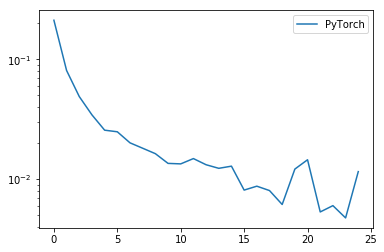

In [13]:
fig, ax = plt.subplots(1,1)
ax.set_yscale('log')
ax.plot(loss_history, label="PyTorch")
ax.legend()

